# AeroGraphNet inference (Ahmed Body)

This notebook uses the [PhysicsNeMo AeroGraphNet checkpoint](https://catalog.ngc.nvidia.com/orgs/nvidia/teams/physicsnemo/models/modulus_ahmed_body_meshgraphnet) to run inference on different Ahmed bodies. The training code and documentation for this checkpoint/model can be found on the GitHub repo [here](https://github.com/NVIDIA/physicsnemo/tree/main/examples/cfd/external_aerodynamics/aero_graph_net/). 

This notebook will use the model that was trained on a dataset of Ahmed bodies of various sizes to infer results and perform some scientific analysis on unseen Ahmed body like geometries. 

## Running Inference

This notebook will use the `AhmedBodyDataset` util from PhysicsNeMo and PyTorch Geometric's `DataLoader` to prepare and load the data. 

The inputs to the model are:
* Ahmed body surface mesh
* Reynolds number
* Geometry parameters (optional, including length, width, height, ground clearance, slant angle, and fillet radius)
* surface normals (optional)

Output of the model are:
* Surface pressure
* Wall shear stresses

The input to the model is in form of a `.vtp` file and is then converted to bi-directional PyG graphs in the dataloader. The final results are also written in the form of `.vtp` files.

Let's begin by first downloading the model package.

In [ ]:
from pathlib import Path

if not Path("ahmed_body_mgn.zip").is_file():
    !wget 'https://api.ngc.nvidia.com/v2/models/nvidia/modulus/modulus_ahmed_body_meshgraphnet/versions/v0.2/files/ahmed_body_mgn.zip'
    !unzip ahmed_body_mgn.zip
    !mv ahmed_body_mgn/* .
    !rm utils.py inference.py # TODO: hacky, remove the old utils.py

We can see that the model checkpoint in the `checkpoints` folder under the name `MeshGraphNet.0.499.mdlus`. We also have a few sample dataset to do the inference on inside the `dataset` directory. Let's start with a few imports

In [ ]:
import sys

import torch
import numpy as np
import wandb as wb

from torch_geometric.data import Data as PyGData
from torch_geometric.loader import DataLoader as PyGDataLoader

from physicsnemo.models.meshgraphnet import MeshGraphNet
from physicsnemo.datapipes.gnn.ahmed_body_dataset import AhmedBodyDataset
from physicsnemo.launch.logging import PythonLogger

import pyvista as pv

if sys.path[0] != "..":
    sys.path.insert(0, "..")

# Helper function to convert PyG graph to PyVista graph for visualization.
# PyVista graph can also be saved as .vtp file for visualization using tools like ParaView.
from inference import pyg_to_pyvista

Next, let's write some steps to load the data and compute the model inference. This portion can be briefly broken down into three major steps, load the data, instantiate the model and load the trained weights and finally compute the model inference on the data. 

In [3]:
import os

from utils import relative_lp_error


class AhmedBodyRollout:
    def __init__(self, wb, logger):
        # set device
        self.device = "cuda" if torch.cuda.is_available() else "cpu"

        logger.info(f"Using {self.device} device")

        # instantiate dataset
        self.dataset = AhmedBodyDataset(
            name="ahmed_body_test",
            data_dir="./dataset",
            split="test",
            num_samples=4,
            compute_drag=True,
        )

        # instantiate dataloader
        self.dataloader = PyGDataLoader(
            self.dataset,
            batch_size=1,
            shuffle=False,
            drop_last=False,
        )

        # instantiate the model
        self.model = MeshGraphNet(
            11,
            4,
            4,
            aggregation="sum",
            hidden_dim_node_encoder=256,
            hidden_dim_edge_encoder=256,
            hidden_dim_node_decoder=256,
        )
        self.model = self.model.to(self.device)

        # enable train mode
        self.model.eval()

        self.model.load(
            "./checkpoints/ahmed_body/MeshGraphNet.0.499.mdlus", strict=False
        )

    def predict(self, save_results=False):
        """
        Run the prediction process.

        Parameters:
        -----------
        save_results: bool
            Whether to save the results in form of a .vtp file, by default False


        Returns:
        --------
        None
        """

        self.pred, self.exact, self.faces, self.graphs = [], [], [], []

        for i, (graph, sid, normals, areas, coeff) in enumerate(self.dataloader):
            graph = graph.to(self.device)
            normals = normals.to(self.device, torch.float32).squeeze()
            areas = areas.to(self.device, torch.float32).squeeze()
            coeff = coeff.to(self.device, torch.float32).squeeze()
            sid = sid.item()
            logger.info(f"Processing sample ID {sid}")
            pred = self.model(graph.x, graph.edge_attr, graph).detach()

            gt = graph.y
            graph.p_pred = pred[:, 0]
            graph.wallShearStress_pred = pred[:, 1:]
            graph.p = gt[:, 0]
            graph.wallShearStress = gt[:, 1:]

            error = relative_lp_error(pred, gt)
            logger.info(f"Test error (%): {error}")

            if save_results:
                # Convert PyG graph to PyVista graph and save it
                os.makedirs("./results_nbk", exist_ok=True)
                pv_graph = pyg_to_pyvista(graph.cpu())
                pv_graph.save(os.path.join("./results_nbk", f"graph_{sid}.vtp"))


logger = PythonLogger("main")  # General python logger
logger.file_logging()

logger.info("Rollout started...")
rollout = AhmedBodyRollout(wb, logger)
rollout.predict(save_results=True)

## Post Processing

Once the results are written, we can visualize them using `trame` which supports interactive visualizations in notebooks.

This might require installing a few additional dependencies, which can be done by uncommenting the below code block:

In [4]:
# %%capture
# %pip install trame-vtk trame-vuetify trame-jupyter-extension

Once you have verified that you have the right dependencies, the results can be visualized by running the following:

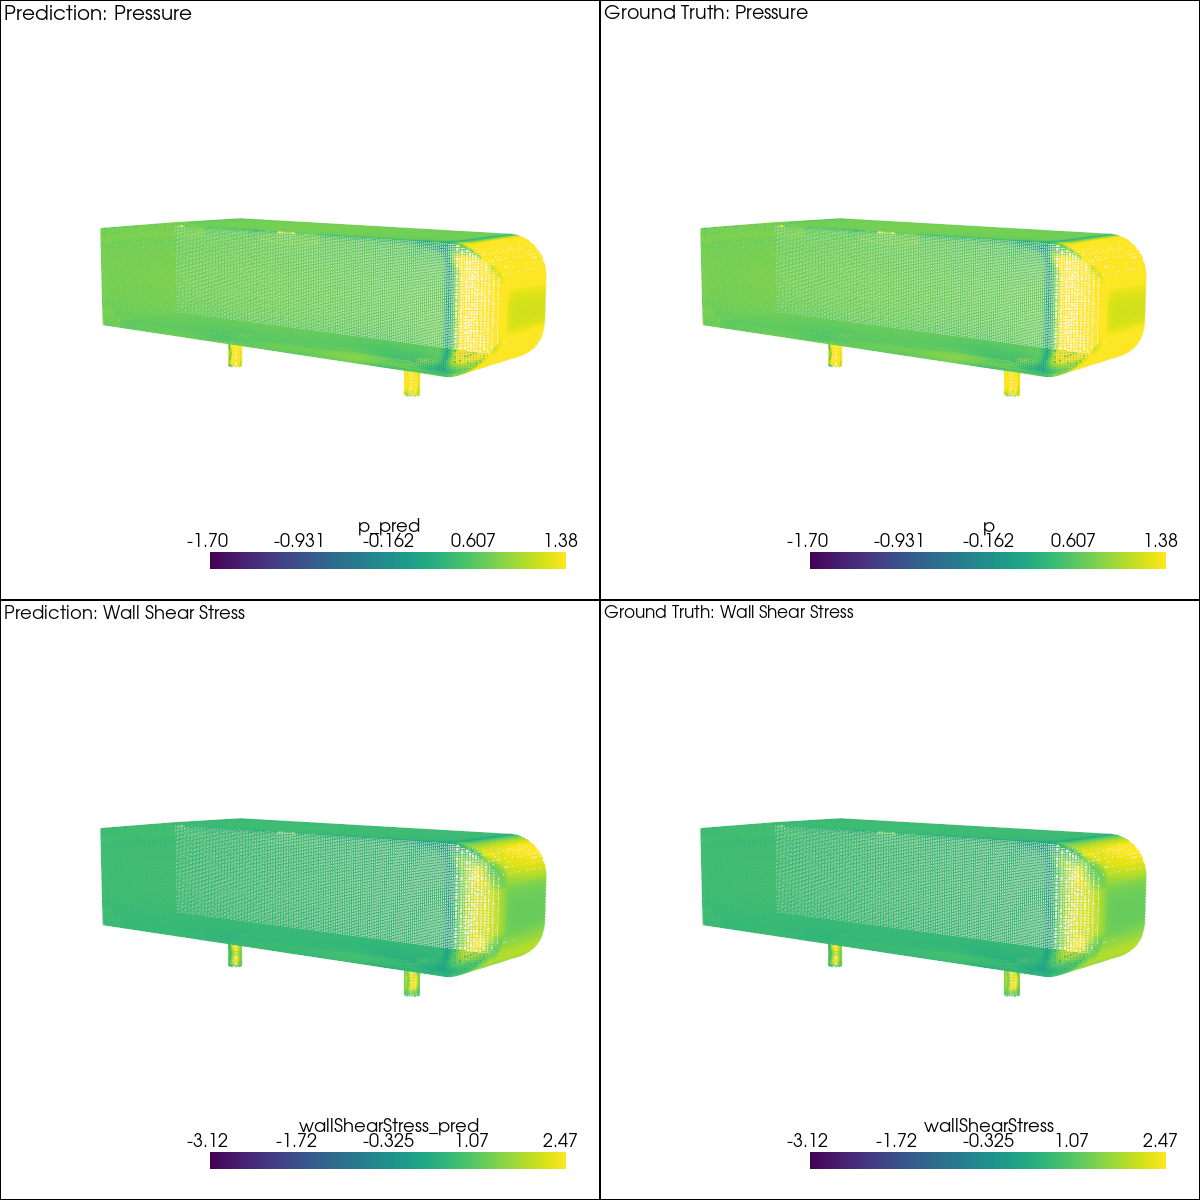

In [5]:
import pyvista as pv
import numpy as np


camera_position = [(-2.0, 2.0, 0.5), (-0.5, 0.12225, 0.15775), (0, 0, 1)]

result = pv.read("./results_nbk/graph_27.vtp")

p_min = result.point_data["p_pred"].min()
p_max = result.point_data["p_pred"].max()
s_min = result.point_data["wallShearStress_pred"].min()
s_max = result.point_data["wallShearStress_pred"].max()

plotter = pv.Plotter(shape=(2, 2), window_size=(1200, 1200))

plotter.subplot(0, 0)
plotter.add_mesh(result, scalars="p_pred", clim=[p_min, p_max])
plotter.add_text("Prediction: Pressure", position="upper_left", font_size=10)
plotter.camera_position = camera_position

plotter.subplot(0, 1)
plotter.add_mesh(result, scalars="p", clim=[p_min, p_max])
plotter.add_text("Ground Truth: Pressure", position="upper_left", font_size=10)
plotter.camera_position = camera_position

plotter.subplot(1, 0)
plotter.add_mesh(result, scalars="wallShearStress_pred", clim=[s_min, s_max])
plotter.add_text("Prediction: Wall Shear Stress", position="upper_left", font_size=10)
plotter.camera_position = camera_position

plotter.subplot(1, 1)
plotter.add_mesh(result, scalars="wallShearStress", clim=[s_min, s_max])
plotter.add_text("Ground Truth: Wall Shear Stress", position="upper_left", font_size=10)
plotter.camera_position = camera_position

plotter.show()

As you can notice, the predictions of the model match well with the ground truth results. 

As one can notice, the current output only provides wireframe output and lacks cell data. In the subsequent steps, we will resample the wireframe data onto a mesh to get more smoother visualization. This will also enable us to compute the surface averaged quantities such as drag coefficients with more accuracy. 

**Note:** To demonstrate this, a sample mesh which contains the cell data has been provided in the package.

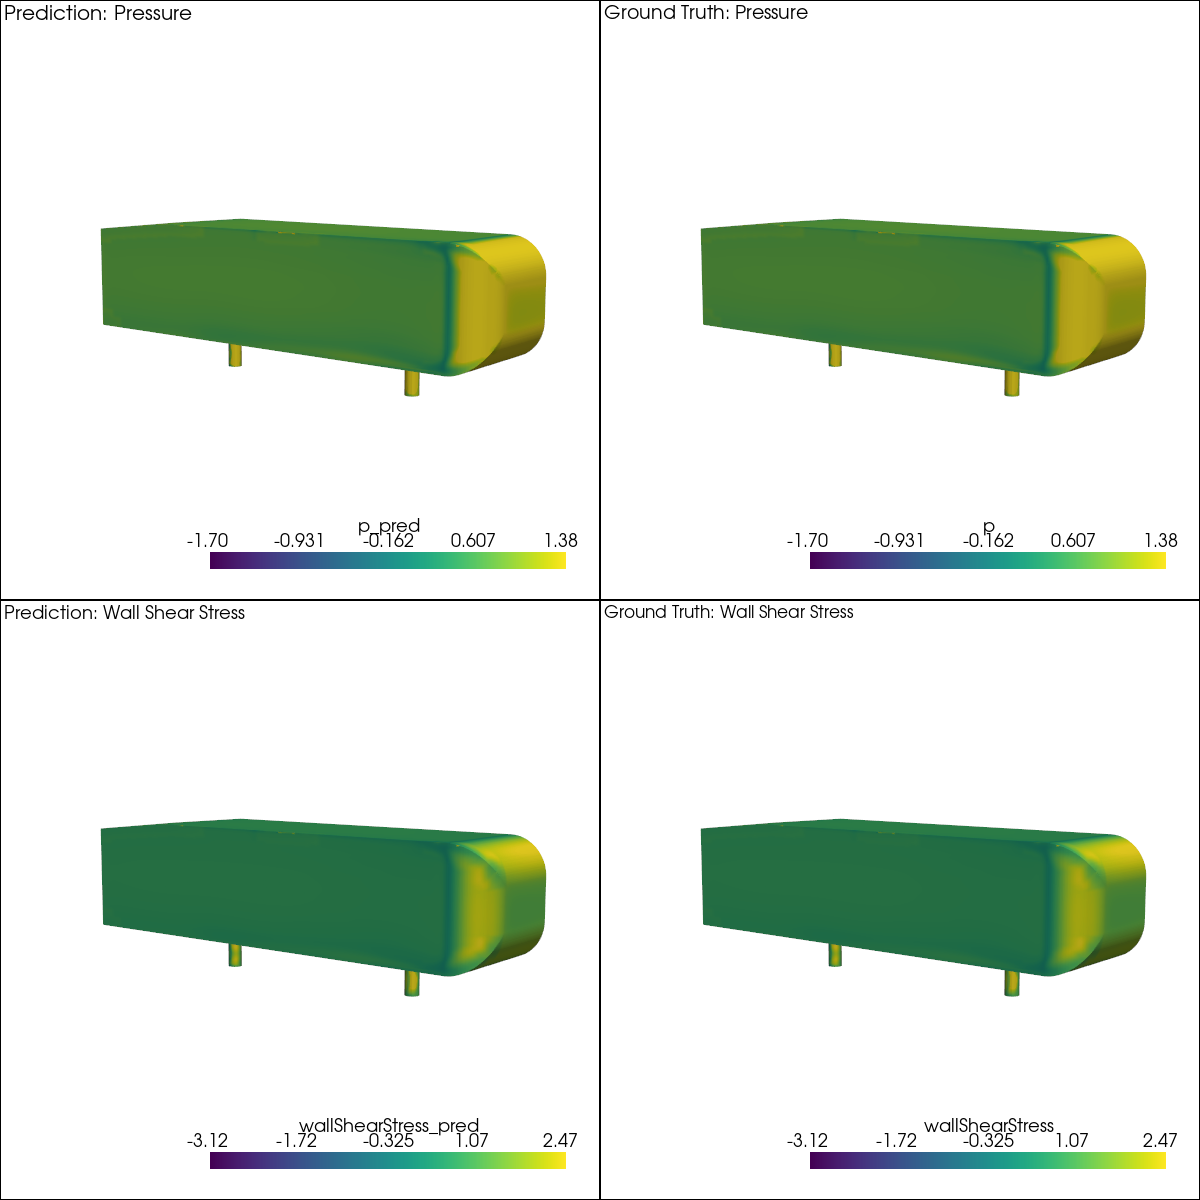

In [6]:
import pyvista as pv
import numpy as np


mesh = pv.read("./case27_surface_mesh.vtp")
camera_position = [(-2.0, 2.0, 0.5), (-0.5, 0.12225, 0.15775), (0, 0, 1)]

data_to_probe = pv.read("./results_nbk/graph_27.vtp")
result = mesh.sample(data_to_probe)

p_min = result.point_data["p_pred"].min()
p_max = result.point_data["p_pred"].max()
s_min = result.point_data["wallShearStress_pred"].min()
s_max = result.point_data["wallShearStress_pred"].max()

plotter = pv.Plotter(shape=(2, 2), window_size=(1200, 1200))

plotter.subplot(0, 0)
plotter.add_mesh(result, scalars="p_pred", clim=[p_min, p_max])
plotter.add_text("Prediction: Pressure", position="upper_left", font_size=10)
plotter.camera_position = camera_position

plotter.subplot(0, 1)
plotter.add_mesh(result, scalars="p", clim=[p_min, p_max])
plotter.add_text("Ground Truth: Pressure", position="upper_left", font_size=10)
plotter.camera_position = camera_position

plotter.subplot(1, 0)
plotter.add_mesh(result, scalars="wallShearStress_pred", clim=[s_min, s_max])
plotter.add_text("Prediction: Wall Shear Stress", position="upper_left", font_size=10)
plotter.camera_position = camera_position

plotter.subplot(1, 1)
plotter.add_mesh(result, scalars="wallShearStress", clim=[s_min, s_max])
plotter.add_text("Ground Truth: Wall Shear Stress", position="upper_left", font_size=10)
plotter.camera_position = camera_position

plotter.show()

### Computing Drag Coefficient

An important metric in aerodynamic analysis is drag coefficient. Prediction of accurate drag coefficient has implications on vehicle performance and efficiency. In the subsequent sections, we will compute the drag coefficient for this Ahmed body configuration. To compute that, we would need to compute the surface area at each cell, compute the cell normals and project the point-data to cells. This can be done using below

In [7]:
result = result.point_data_to_cell_data()
result = result.compute_normals()
result = result.compute_cell_sizes()
result

PolyData (0x7fc6348cd180)
  N Cells:    70805
  N Points:   71174
  N Strips:   0
  X Bounds:   -1.019e+00, -9.082e-17
  Y Bounds:   0.000e+00, 2.445e-01
  Z Bounds:   0.000e+00, 3.155e-01
  N Arrays:   15

In [8]:
import json

from physicsnemo.metrics.cae.cfd import compute_force_coefficients, compute_frontal_area

# Load the stats to denormalize the data
f = open("node_stats.json")
stats = json.load(f)

# Load case info to read velocity and relevant info
data = np.loadtxt("./dataset/test_info/case27_info.txt", usecols=(2), max_rows=7)
velocity = data[-1]

p_true = result.cell_data["p"] * stats["p_std"] + stats["p_mean"]
p_pred = result.cell_data["p_pred"] * stats["p_std"] + stats["p_mean"]
wss_true = (
    result.cell_data["wallShearStress"] * stats["wallShearStress_std"]
    + stats["wallShearStress_mean"]
)
wss_pred = (
    result.cell_data["wallShearStress_pred"] * stats["wallShearStress_std"]
    + stats["wallShearStress_mean"]
)

frontal_area = compute_frontal_area(result, direction="x")
normals = result.cell_data["Normals"]
areas = result.cell_data["Area"]

coeff = 2 / (frontal_area * 1.225 * velocity**2)

cd_true, _, _ = compute_force_coefficients(
    normals, areas, coeff, p_true, wss_true, np.array([1, 0, 0])
)
cd_pred, _, _ = compute_force_coefficients(
    normals, areas, coeff, p_pred, wss_pred, np.array([1, 0, 0])
)

print(cd_true, cd_pred)

0.23073415190620303 0.20531973401498171


This completes the inference analysis for the Ahmed body checkpoint. 